In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *
import celerite
from celerite import terms
from scipy.optimize import minimize

In [2]:
tic = 404850274

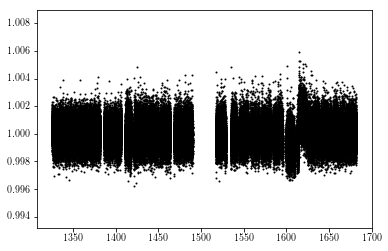

In [3]:
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
plt.scatter(lc['Time'],lc['Flux'],s=1,c='k')

In [4]:
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time,flux,dy=err)
freq,power=ls.autopower()

(0, 10)

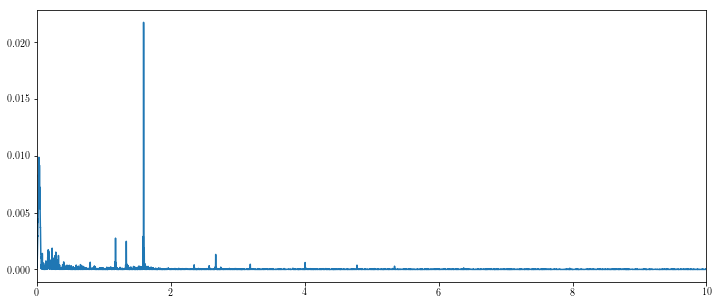

In [5]:
fig=plt.figure(figsize=(12,5))
plt.plot(freq,power)
plt.xlim(0,10)

In [6]:
#Let's try a Wavelet Transform!!
#Let's put our basis functions and scaling function into memory for later
func_list = [phi_1,phi_2,phi_3]
f1 = phi_1 #we're also going to need this one explicitly later
c = 0.0125

y = flux.values
t = time.values
omega_start = -4 #log2(1/32)
omega_end = 6 #log2(16) 
omegas = np.logspace(omega_start,omega_end,250,base=2)
taus = np.linspace(np.min(t),np.max(t),500)
wwz,wwa = MP_WWZ(func_list,f1,y,t,omegas,taus,c=c)

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


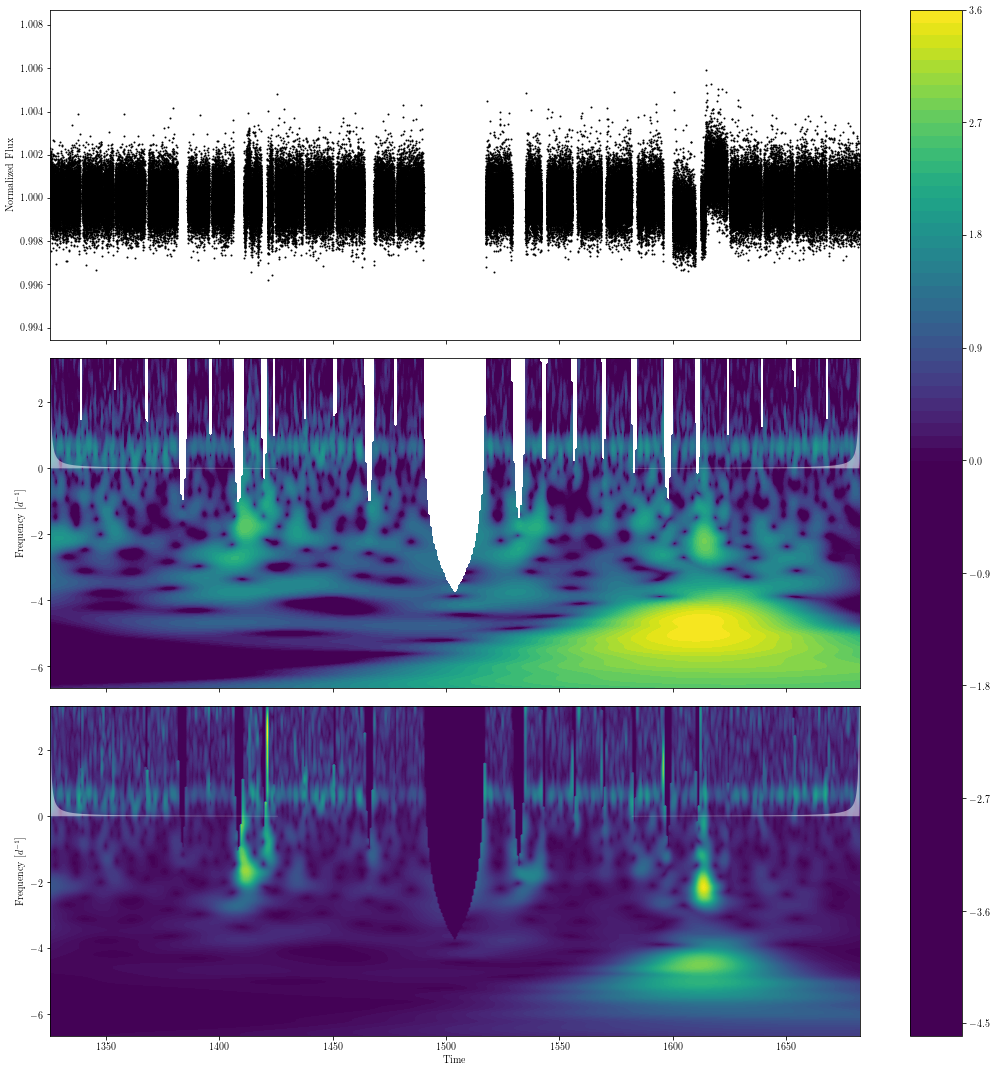

In [12]:
fig,ax = plt.subplots(3,figsize=(15,15),sharex=True)
ax[0].scatter(time,flux,s=1,c='k')
mesh = ax[1].contourf(taus,np.log2(omegas/2.0/np.pi),np.log10(wwz),levels=100,vmin=0)
max_peak_WWZ = [omegas[t==m][0] if not np.isnan(m) else np.nan for t,m in zip(wwz.T,np.max(wwz,axis=0))]
max_peak_WWA = [amp[omegas==m][0] if not np.isnan(m) else np.nan for amp,m in zip(wwa.T,max_peak_WWZ)]
yl = ax[1].get_ylim()
#ax[1].step(taus,np.array(max_peak_WWZ)/2/np.pi,where='mid',c='white')
ax[2].contourf(taus,np.log2(omegas/2.0/np.pi),wwa,levels=100)
ax[1].fill_between(2*np.pi/omegas+np.min(t),0,omegas/2/np.pi,alpha=0.5,facecolor='white')
ax[1].fill_between(np.max(t)-2*np.pi/omegas,0,omegas/2/np.pi,alpha=0.5,facecolor='white')
ax[1].set(ylim=yl,ylabel='Frequency [$d^{-1}$]')
yl = ax[2].get_ylim()
ax[2].fill_between(2*np.pi/omegas+np.min(t),0,omegas/2/np.pi,alpha=0.5,facecolor='white')
ax[2].fill_between(np.max(t)-2*np.pi/omegas,0,omegas/2/np.pi,alpha=0.5,facecolor='white')
ax[2].set(ylim=yl,xlabel='Time',ylabel='Frequency [$d^{-1}$]')
ax[0].set(ylabel='Normalized Flux')
fig.tight_layout()
plt.colorbar(mappable=mesh,ax=ax)

(1.1180570197059719e-06, 0.0005628635924715011)

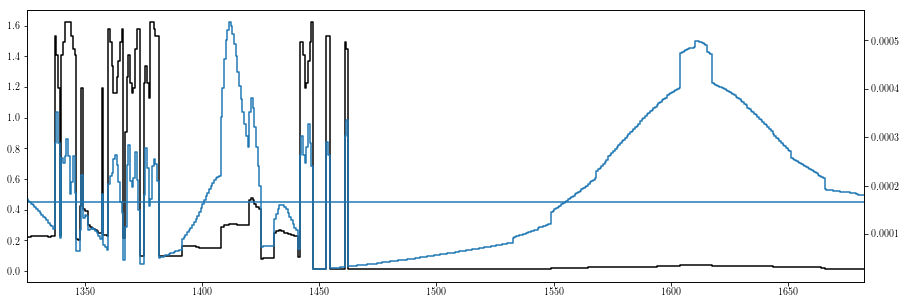

In [9]:
fig = plt.figure(figsize=(15,5))
plt.step(taus,np.array(max_peak_WWZ)/2.0/np.pi,c='k',where='mid')
plt.axhline(y=0.45)
ax = plt.gca().twinx()
ax.step(taus,max_peak_WWA,where='mid')
yl = ax.get_ylim()
plt.xlim(np.min(taus),np.max(taus))
plt.ylim(0,2.5)
ax.set_ylim(yl)

f_Ny = 323.89171072083246, f_R = 0.01778794028727421
10
Found 14 frequencies
14 unique frequencies


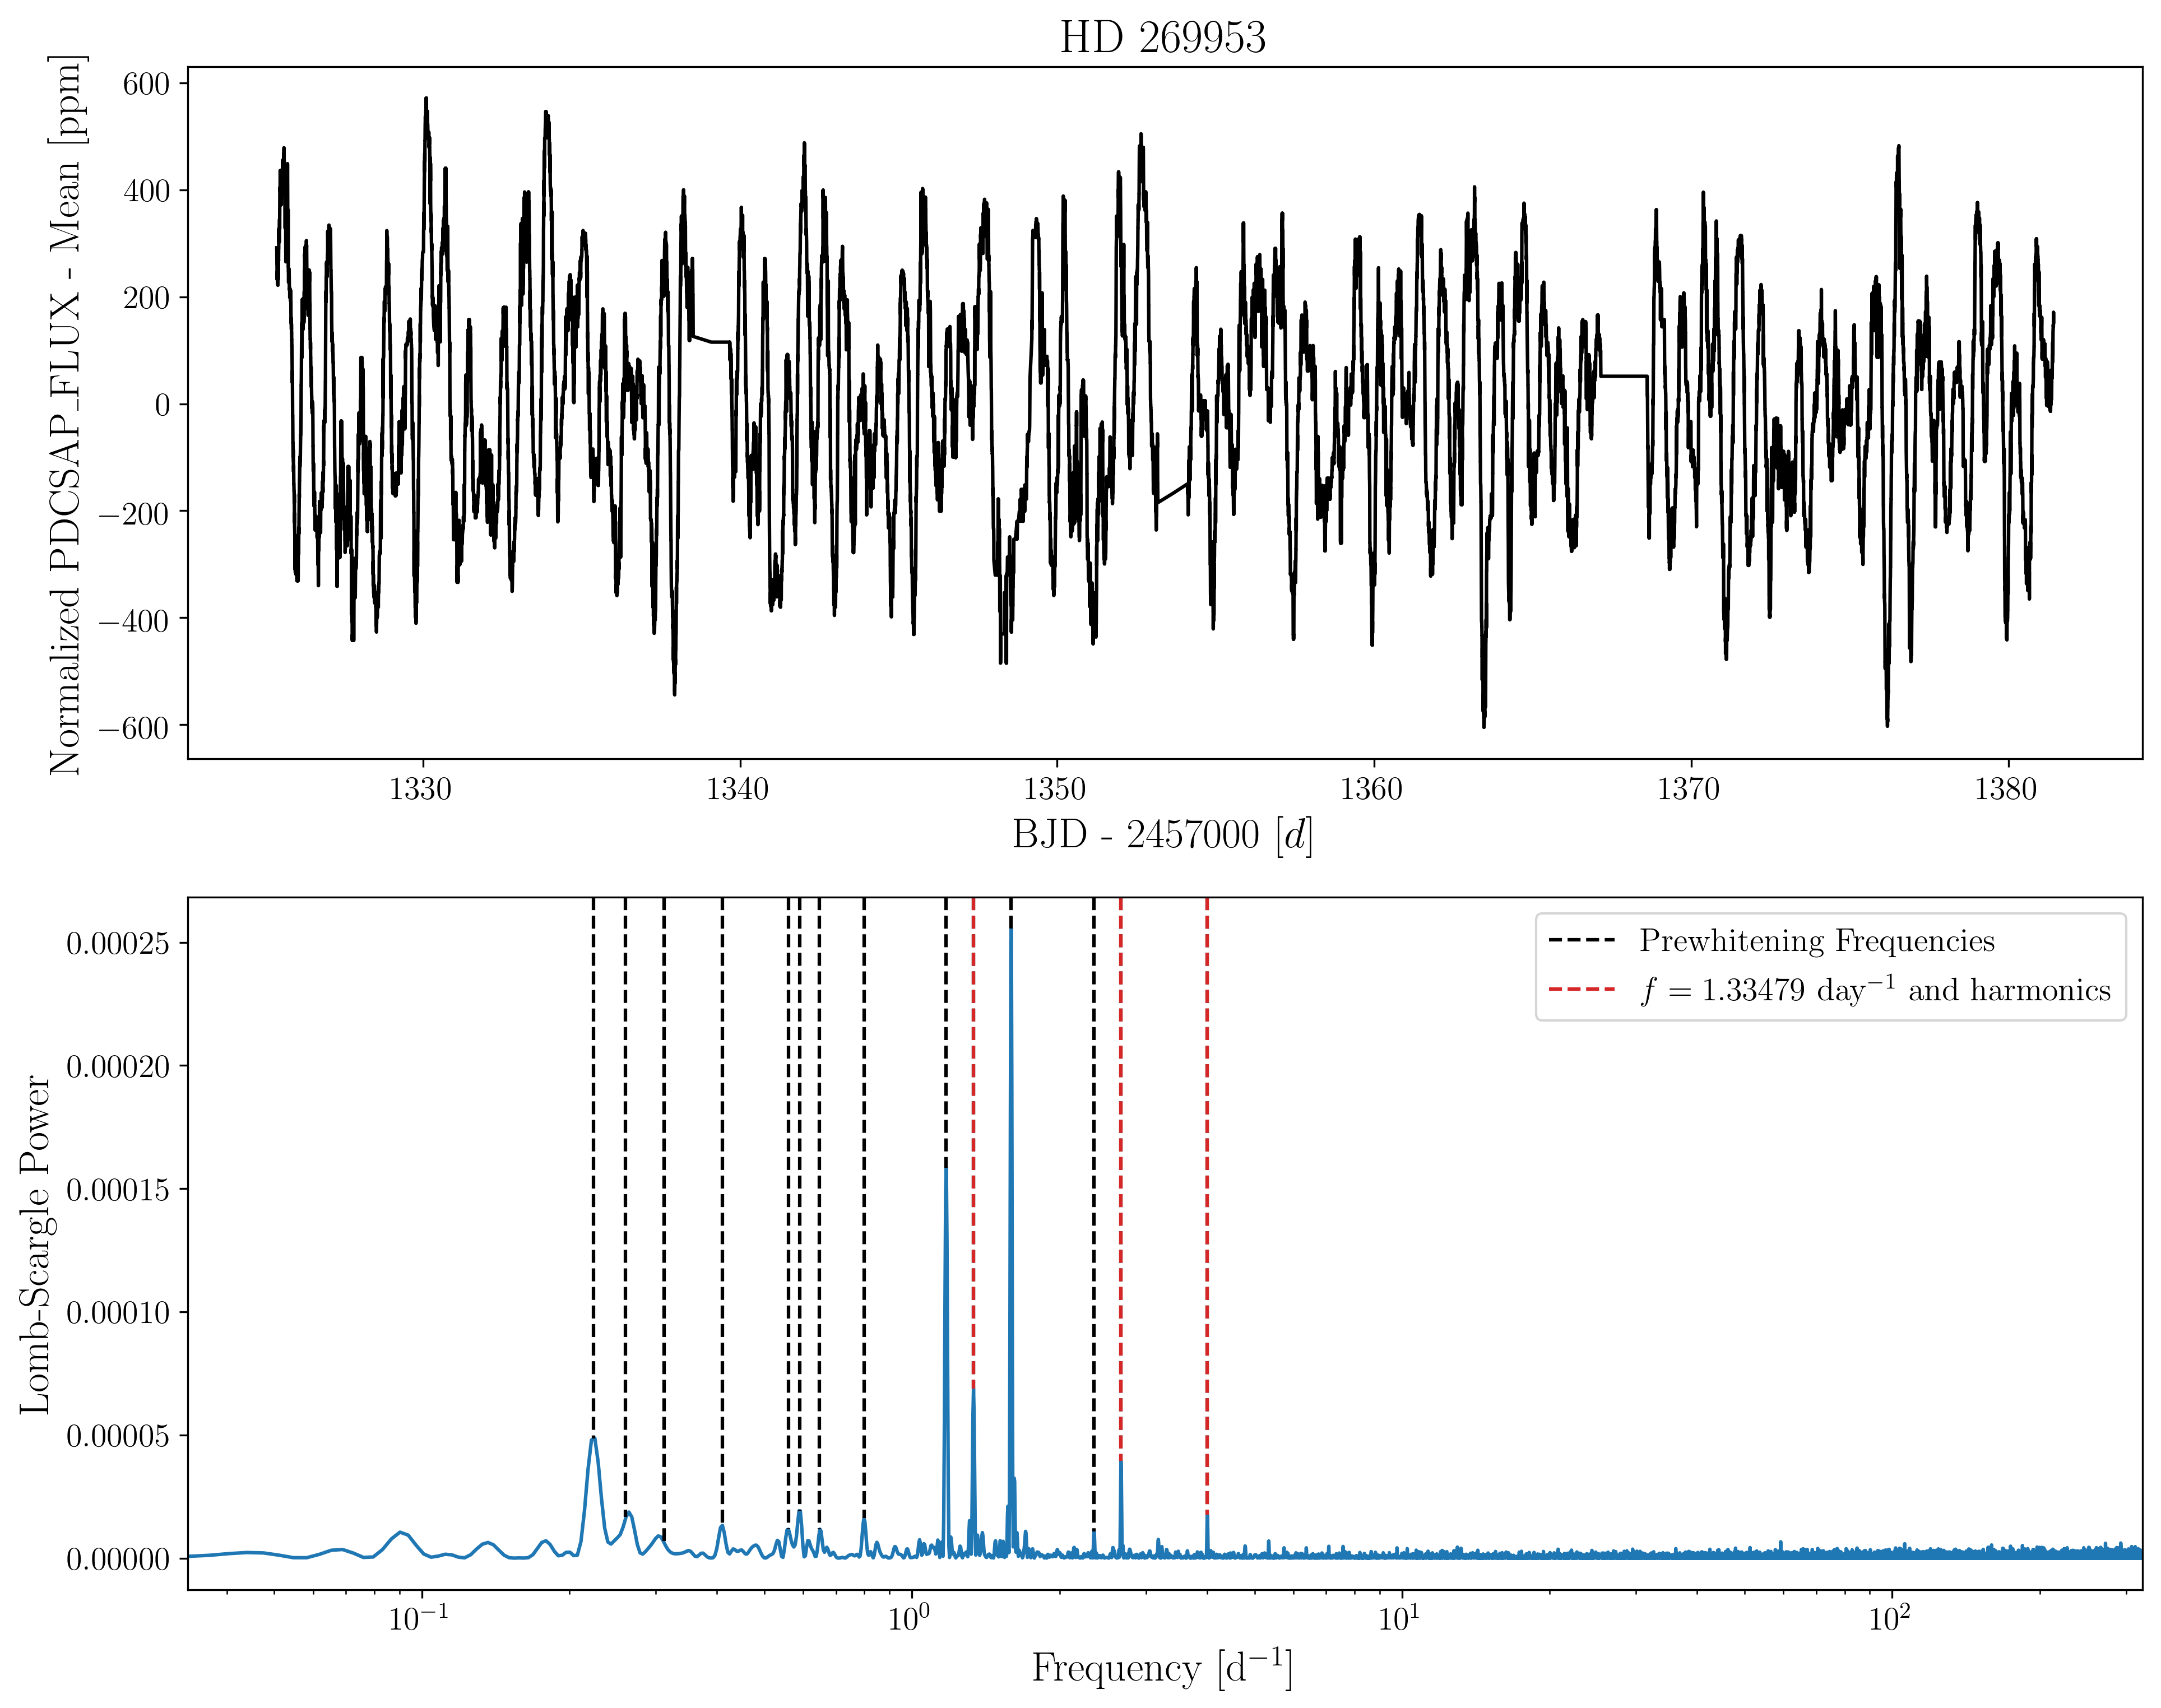

In [4]:
fig, ax = plt.subplots(2, figsize=(15,12),dpi=300)
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
ax[0].plot(lc_smooth['Time'],1e6*(lc_smooth['Flux']-np.mean(lc_smooth['Flux'])),c='k')
ax[0].set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX - Mean [ppm]')


time, flux, err = lc['Time'], lc['Flux'], lc['Err']
pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 

good_fs, good_amps, good_phases = prewhiten(time, flux, err)

harmonics = harmonic_search(good_fs)

ax[1].plot(freq, power)

ax[1].set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax[1].get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='k',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='k',ls='--')

fundamental = harmonics[0,0]
harmonic = harmonics[1,:2]
plt.plot([fundamental,fundamental],[ylim[1],power[np.argmin(np.abs(freq-1.33479))]],c='C3',ls='--',label='$f=1.33479$ day$^{-1}$ and harmonics')
for h in harmonic:
    plt.plot([h,h],[ylim[1],power[np.argmin(np.abs(freq-h))]],c='C3',ls='--')

ax[1].set(ylim=ylim)
ax[1].legend(fontsize=14)
    
for a in ax:
    a.xaxis.label.set_size(18)
    a.yaxis.label.set_size(18)
    for tick in a.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in a.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
        
ax[0].set_title('HD 269953',fontsize=20)
plt.savefig('../plots/HD269953_lcperiod.pdf')

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:111: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


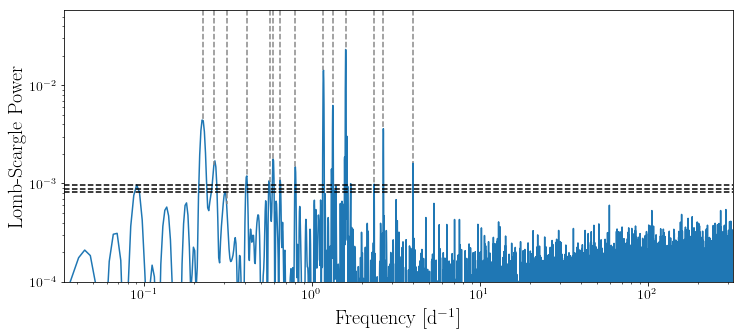

In [9]:
fig = plt.figure(figsize=(12,5))
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
lc = polynorm(lc, deg=7)[0]
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time, flux)
freq, power = ls.autopower() 
plt.loglog(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]',ylabel='Lomb-Scargle Power', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
   
ax.set(ylim=(1e-4,ylim[1]))

probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities)
for f in fal:
    plt.axhline(y=f,c='k',ls='--')
        
#plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

In [8]:
harmonics

array([[1.33479243, 1.33479243, 0.26019548],
       [2.67017901, 4.00557547, 2.35305773],
       [2.        , 3.        , 9.        ]])